In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')

## Data Reading, Factorial Design Understanding, Interpretation and Pre-Processing

In [ ]:
gambling_dataset = pd.read_csv('final_data.csv')
gambling_dataset.rename({'Choice_':'choice'},axis = 1, inplace = True)

### Factorial Design

###### Since the columns created below for modeling are dependent on either columns or variables defined later on, Factorial Design is done on the factors present in the above dataset.

In [ ]:
gambling_dataset

,subject,trial,choice,reward,goodness,loss_frequency
0,Subj_1,1,4,-200,good,low
1,Subj_2,1,1,-150,bad,high
2,Subj_3,1,2,100,bad,low
3,Subj_4,1,4,50,good,low
4,Subj_5,1,4,50,good,low
...,...,...,...,...,...,...
14695,Subj_94,150,4,50,good,low
14696,Subj_95,150,3,50,good,high
14697,Subj_96,150,4,-200,good,low
14698,Subj_97,150,4,50,good,low


##### In the above dataset, the factors present and which can be used to design an experiment aka factors required are the columns subject, trial and no of choices (it might not be a factor as such which is used to design the experiment, the actual factor for designing it might be the reward scale for each deck).
##### If considered separately, the combinations of subject and trial are full factorial as in a complete crossing whereas including choice a combination of (subj, trial) can have one choice out of the four.
##### These choices have rewards based on certain probabilities for pbtaining different values which lead towards the choices.

##### Thus, the above dataset could be called a partial factorial design

### Data Analysis and Preprocessing

##### Checking the loss frequency of each choice

In [ ]:
choice_loss_data = gambling_dataset[['choice', 'loss_frequency']].drop_duplicates()
choice_loss_data

,choice,loss_frequency
0,4,low
1,1,high
2,2,low
7,3,high


##### Checking the goodness of each choice

In [ ]:
choice_goodness_data = gambling_dataset[['choice', 'goodness']].drop_duplicates()
choice_goodness_data

,choice,goodness
0,4,good
1,1,bad
2,2,bad
7,3,good


##### All subjects trial count

In [ ]:
gambling_dataset.subject.value_counts().unique()

array([150])

##### Type of rewards and no of occurrences

In [ ]:
gambling_dataset.reward.value_counts()

 50      5746
 100     5040
 0       2069
-200      603
-1150     457
-150      200
-250      199
-50       195
-100      191
Name: reward, dtype: int64

##### Choices ranked based on their frequency of pick

In [ ]:
gambling_dataset.choice.value_counts()

2    4563
3    4119
4    4115
1    1903
Name: choice, dtype: int64

##### Choice based average rewards

In [ ]:
gambling_dataset[['choice', 'reward']].groupby('choice').mean('reward')

,reward
choice,
1,-27.325276
2,-25.191760
3,24.884681
4,24.544350


##### Choice to reward mapping & Rewards/Loss Frequencies

In [ ]:
choice_reward_ratio = pd.DataFrame(gambling_dataset[['choice', 'reward']].value_counts()).reset_index()
choice_reward_ratio.rename({0:'frequency'}, axis = 1, inplace = True)
join_choice_reward_ratio = choice_reward_ratio.groupby('choice')['frequency'].sum()
choice_reward_ratio['total'] = choice_reward_ratio['choice'].map(join_choice_reward_ratio)
choice_reward_ratio['percent_frequency'] = (choice_reward_ratio['frequency']/choice_reward_ratio['total']).round(2)*100
choice_reward_ratio.drop('total',axis = 1, inplace = True)
choice_reward_ratio

,choice,reward,frequency,percent_frequency
0,2,100,4106,90.0
1,4,50,3696,90.0
2,3,0,2069,50.0
3,3,50,2050,50.0
4,1,100,934,49.0
5,2,-1150,457,10.0
6,4,-200,419,10.0
7,1,-150,200,11.0
8,1,-250,199,10.0
9,1,-50,195,10.0


##### Calculating final scores after starting with 1000

In [ ]:
gambling_dataset = gambling_dataset.sort_values(by=['subject', 'trial'])
gambling_dataset['present_score'] = gambling_dataset.groupby('subject')['reward'].cumsum()
gambling_dataset['present_score'] += 1000
gambling_dataset['choice'] -=1
gambling_dataset.reset_index(drop = True)

,subject,trial,choice,reward,goodness,loss_frequency,present_score
0,Subj_1,1,3,-200,good,low,800
1,Subj_1,2,0,100,bad,high,900
2,Subj_1,3,0,-250,bad,high,650
3,Subj_1,4,0,100,bad,high,750
4,Subj_1,5,2,50,good,high,800
...,...,...,...,...,...,...,...
14695,Subj_98,146,3,50,good,low,-1150
14696,Subj_98,147,1,100,bad,low,-1050
14697,Subj_98,148,1,100,bad,low,-950
14698,Subj_98,149,3,50,good,low,-900


##### Plotting the Safe vs Risky Choices per block

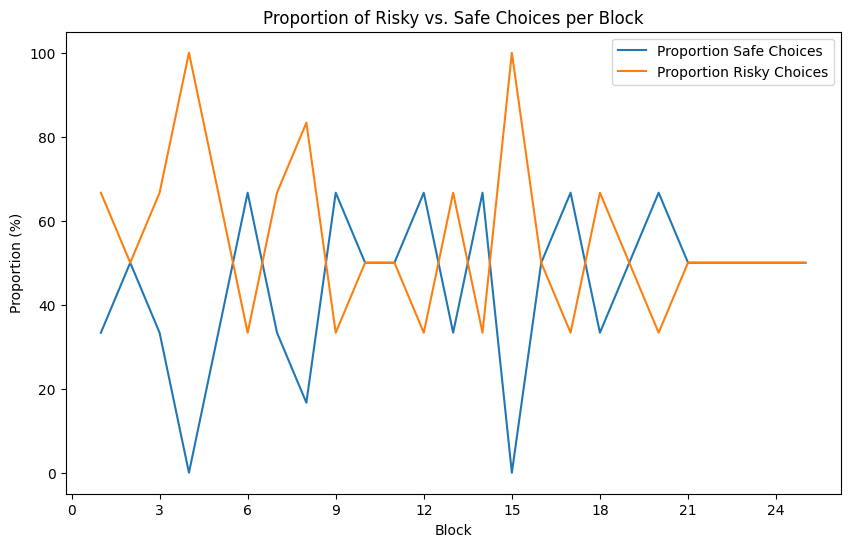

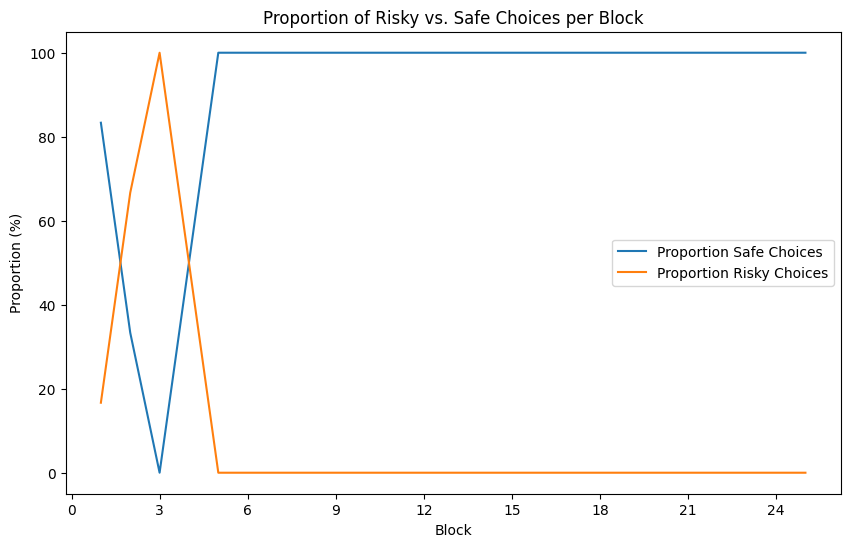

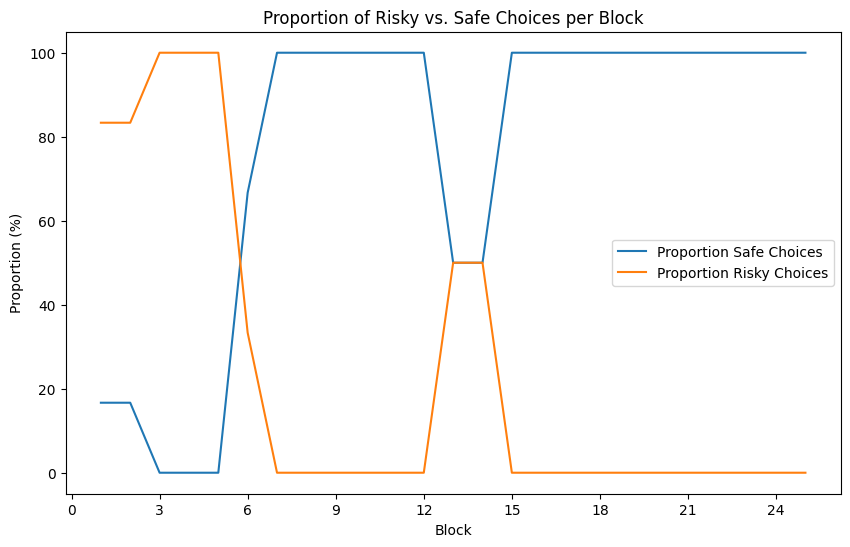

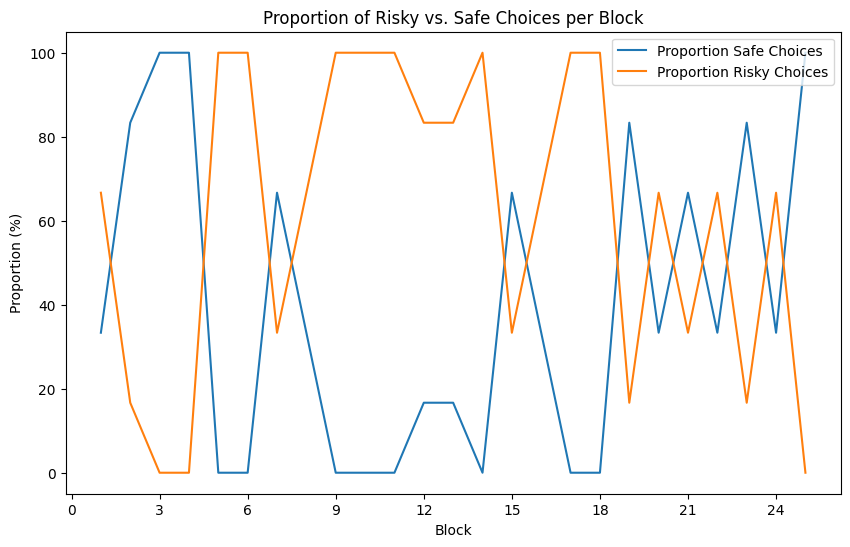

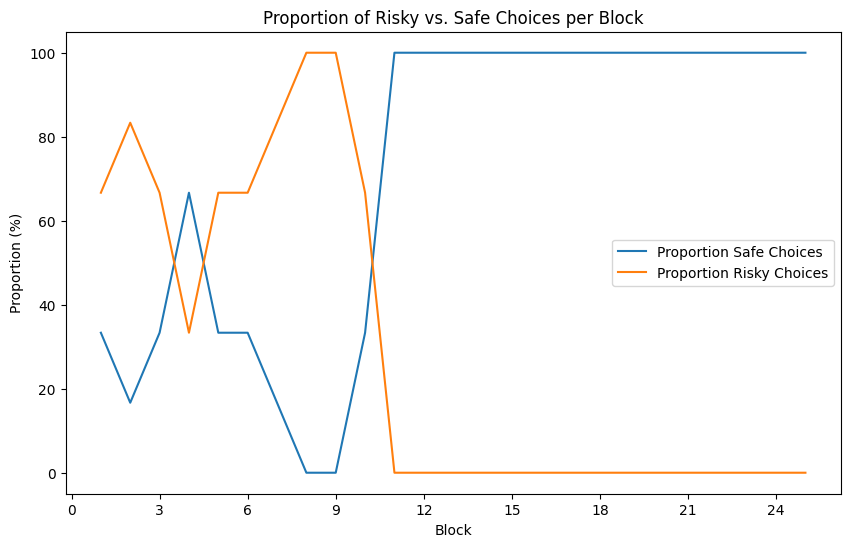

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# load data

def plot_deck_choices(data, block_size = 6):
    # some analysis parameters
    num_blocks = len(data.index) // block_size
    # Create a new column 'block' by dividing 'trial_index' by 25 and rounding up to create blocks
    data['block'] = (data['trial']) // block_size + 1
    # Group the DataFrame by 'block' and 'risky_deck', and calculate the proportions
    block_proportions = data.groupby(['block', 'goodness'])['goodness'].count() / block_size
    # Convert the Series to a DataFrame and drop the 'risky_deck' column
    proportion_safe = list()

    # compute proportion safe choices per block
    for i in range(num_blocks):
        condition = (data['block'] == i + 1) & (data['goodness'] == 'good')
        proportion_safe.append(condition.sum())

    # arrange data
    proportion_safe = np.array(proportion_safe)/block_size
    proportion_risky = 1 - proportion_safe
    blocks = np.arange(1, num_blocks+1)

    # Create a line plot
    plt.figure(figsize=(10, 6))
    plt.plot(blocks, proportion_safe * 100, label='Proportion Safe Choices')
    plt.plot(blocks, proportion_risky * 100, label='Proportion Risky Choices')

    # Customize the plot
    plt.xlabel('Block')
    plt.ylabel('Proportion (%)')
    plt.title('Proportion of Risky vs. Safe Choices per Block')
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for i in list(gambling_dataset['subject'].unique())[:5]:
    data = gambling_dataset[gambling_dataset['subject']==i].reset_index()
    plot_deck_choices(data)


#### Creating these blocks, modeling them using different active learners while categorising them into 4 categories:
* 1) More risky choices but >threshold score in the end
* 2) Less risky choices but >threshold score in the end
* 3) More risky choices but <threshold score in the end
* 4) Less risky choices but <threshold score in the end

##### Creating blocks and using a threshold, checking the final score

In [ ]:
block_size = 6
score_set = 1000

gambling_dataset['block'] = (gambling_dataset['trial']) // block_size + 1

subj_last_score = gambling_dataset[['subject', 'trial', 'present_score']][gambling_dataset['trial']==150].drop_duplicates().reset_index(drop = True)
subj_last_score['last_score'] = 0
subj_last_score['last_score'] = np.where(subj_last_score['present_score'] >= score_set, 1, subj_last_score['last_score'])
subj_last_score.drop(['trial', 'present_score'], axis = 1, inplace = True)
gambling_dataset = pd.merge(gambling_dataset, subj_last_score, on = 'subject', how = 'left')

##### Bad decks overall choice count

In [ ]:
risky_counts = gambling_dataset.groupby('subject')['goodness'].apply(lambda x: (x == 'bad').sum()).reset_index(name='risky_choice_overall_count')
gambling_dataset = pd.merge(gambling_dataset, risky_counts, on='subject', how='left')
gambling_dataset

,subject,trial,choice,reward,goodness,loss_frequency,present_score,block,last_score,risky_choice_overall_count
0,Subj_1,1,3,-200,good,low,800,1,0,83
1,Subj_1,2,0,100,bad,high,900,1,0,83
2,Subj_1,3,0,-250,bad,high,650,1,0,83
3,Subj_1,4,0,100,bad,high,750,1,0,83
4,Subj_1,5,2,50,good,high,800,1,0,83
...,...,...,...,...,...,...,...,...,...,...
14695,Subj_98,146,3,50,good,low,-1150,25,0,115
14696,Subj_98,147,1,100,bad,low,-1050,25,0,115
14697,Subj_98,148,1,100,bad,low,-950,25,0,115
14698,Subj_98,149,3,50,good,low,-900,25,0,115


In [ ]:
risky_block_counts = gambling_dataset.groupby(['subject', 'block'])['goodness'].apply(lambda x: (x == 'bad').sum()).reset_index(name='risky_choice_block_count')
gambling_dataset = pd.merge(gambling_dataset, risky_block_counts, on=['subject', 'block'], how='left')
gambling_dataset

,subject,trial,choice,reward,goodness,loss_frequency,present_score,block,last_score,risky_choice_overall_count,risky_choice_block_count
0,Subj_1,1,3,-200,good,low,800,1,0,83,3
1,Subj_1,2,0,100,bad,high,900,1,0,83,3
2,Subj_1,3,0,-250,bad,high,650,1,0,83,3
3,Subj_1,4,0,100,bad,high,750,1,0,83,3
4,Subj_1,5,2,50,good,high,800,1,0,83,3
...,...,...,...,...,...,...,...,...,...,...,...
14695,Subj_98,146,3,50,good,low,-1150,25,0,115,4
14696,Subj_98,147,1,100,bad,low,-1050,25,0,115,4
14697,Subj_98,148,1,100,bad,low,-950,25,0,115,4
14698,Subj_98,149,3,50,good,low,-900,25,0,115,4


In [ ]:
gambling_dataset['risky_choice_block_percent'] = (gambling_dataset['risky_choice_block_count']/block_size).round(4)*100
gambling_dataset['safe_choice_block_percent'] = 100 - gambling_dataset['risky_choice_block_percent']
gambling_dataset

,subject,trial,choice,reward,goodness,loss_frequency,present_score,block,last_score,risky_choice_overall_count,risky_choice_block_count,risky_choice_block_percent,safe_choice_block_percent
0,Subj_1,1,3,-200,good,low,800,1,0,83,3,50.00,50.00
1,Subj_1,2,0,100,bad,high,900,1,0,83,3,50.00,50.00
2,Subj_1,3,0,-250,bad,high,650,1,0,83,3,50.00,50.00
3,Subj_1,4,0,100,bad,high,750,1,0,83,3,50.00,50.00
4,Subj_1,5,2,50,good,high,800,1,0,83,3,50.00,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14695,Subj_98,146,3,50,good,low,-1150,25,0,115,4,66.67,33.33
14696,Subj_98,147,1,100,bad,low,-1050,25,0,115,4,66.67,33.33
14697,Subj_98,148,1,100,bad,low,-950,25,0,115,4,66.67,33.33
14698,Subj_98,149,3,50,good,low,-900,25,0,115,4,66.67,33.33


##### Creating the score at the end of the block and average rewards to be used as parameters

In [ ]:
risk_take_parameter = 75
gambling_dataset['risk_taking'] = 0
gambling_dataset['risk_taking'] = np.where(gambling_dataset['risky_choice_overall_count'] >= risk_take_parameter, 1, gambling_dataset['risk_taking'])
gambling_dataset

,subject,trial,choice,reward,goodness,loss_frequency,present_score,block,last_score,risky_choice_overall_count,risky_choice_block_count,risky_choice_block_percent,safe_choice_block_percent,risk_taking
0,Subj_1,1,3,-200,good,low,800,1,0,83,3,50.00,50.00,1
1,Subj_1,2,0,100,bad,high,900,1,0,83,3,50.00,50.00,1
2,Subj_1,3,0,-250,bad,high,650,1,0,83,3,50.00,50.00,1
3,Subj_1,4,0,100,bad,high,750,1,0,83,3,50.00,50.00,1
4,Subj_1,5,2,50,good,high,800,1,0,83,3,50.00,50.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14695,Subj_98,146,3,50,good,low,-1150,25,0,115,4,66.67,33.33,1
14696,Subj_98,147,1,100,bad,low,-1050,25,0,115,4,66.67,33.33,1
14697,Subj_98,148,1,100,bad,low,-950,25,0,115,4,66.67,33.33,1
14698,Subj_98,149,3,50,good,low,-900,25,0,115,4,66.67,33.33,1


In [ ]:
block_last_values = gambling_dataset.groupby(['subject', 'block'])['present_score'].last().reset_index()
avg_rewards = gambling_dataset.groupby(['subject', 'block'])['reward'].mean().round(2).reset_index()

In [ ]:
gambling_subset = gambling_dataset[['subject','block','last_score','risk_taking','risky_choice_block_percent','safe_choice_block_percent']].drop_duplicates().reset_index(drop = True)
gambling_subset

,subject,block,last_score,risk_taking,risky_choice_block_percent,safe_choice_block_percent
0,Subj_1,1,0,1,50.00,50.00
1,Subj_1,2,0,1,50.00,50.00
2,Subj_1,3,0,1,66.67,33.33
3,Subj_1,4,0,1,100.00,0.00
4,Subj_1,5,0,1,66.67,33.33
...,...,...,...,...,...,...
2543,Subj_98,22,0,1,50.00,50.00
2544,Subj_98,23,0,1,50.00,50.00
2545,Subj_98,24,0,1,83.33,16.67
2546,Subj_98,25,0,1,66.67,33.33


In [ ]:
modelling_dataset = pd.merge(gambling_subset, block_last_values, on=['subject', 'block'], how='left')
modelling_dataset = pd.merge(modelling_dataset, avg_rewards, on=['subject', 'block'], how='left')
modelling_dataset

,subject,block,last_score,risk_taking,risky_choice_block_percent,safe_choice_block_percent,present_score,reward
0,Subj_1,1,0,1,50.00,50.00,800,-40.00
1,Subj_1,2,0,1,50.00,50.00,1050,41.67
2,Subj_1,3,0,1,66.67,33.33,1250,33.33
3,Subj_1,4,0,1,100.00,0.00,950,-50.00
4,Subj_1,5,0,1,66.67,33.33,150,-133.33
...,...,...,...,...,...,...,...,...
2543,Subj_98,22,0,1,50.00,50.00,-900,75.00
2544,Subj_98,23,0,1,50.00,50.00,-700,33.33
2545,Subj_98,24,0,1,83.33,16.67,-1400,-116.67
2546,Subj_98,25,0,1,66.67,33.33,-900,83.33


### Modeling Datasets creation and using Active Learners with estimators as well as Committee Regressors

##### Creating the 4 subsets

In [ ]:
agg_profit = modelling_dataset[(modelling_dataset['last_score']==1)&(modelling_dataset['risk_taking']==1)]
agg_loss = modelling_dataset[(modelling_dataset['last_score']==0)&(modelling_dataset['risk_taking']==1)]
passive_profit = modelling_dataset[(modelling_dataset['last_score']==1)&(modelling_dataset['risk_taking']==0)]
passive_loss = modelling_dataset[(modelling_dataset['last_score']==0)&(modelling_dataset['risk_taking']==0)]
print(len(agg_profit), len(agg_loss), len(passive_profit), len(passive_loss))

286 806 1352 104


##### Committee modeling passive_profit

In [ ]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-x6p6wns7
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-x6p6wns7
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done


In [ ]:
test_sub_num = int(len(passive_profit.subject.unique())*0.2)
test_subjects = list(passive_profit.subject.unique())[-test_sub_num:]
training = passive_profit[~passive_profit['subject'].isin(test_subjects)]
testing = passive_profit[passive_profit['subject'].isin(test_subjects)]

x_training = training[['block','present_score','reward']].reset_index(drop = True)
y_training = training['risky_choice_block_percent'].reset_index(drop = True)

x_test = testing[['block','present_score','reward']].reset_index(drop = True)
y_test = testing['risky_choice_block_percent'].reset_index(drop = True)

In [ ]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling
from sklearn.metrics import mean_absolute_error
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from xgboost import XGBRegressor
from modAL.models import ActiveLearner, CommitteeRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from modAL.disagreement import max_std_sampling
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner, CommitteeRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from modAL.disagreement import max_std_sampling
import numpy as np
import pandas as pd


# Number of regressors (learners) in the ensemble
n_regressors = 10

# Number of initial training samples
n_initial = 50

# get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial * n_regressors, replace=False)
initial_idx = initial_idx.reshape(n_regressors, -1).T  # reshape to list of lists

# define a kernel for the Gaussian process regressor
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# initializing the Committee
learner_list = []
for idx_learner in range(n_regressors):
    learner_list.append(
        ActiveLearner(
            estimator=GPR(kernel),
            X_training=x_training.iloc[initial_idx[:, idx_learner]].values,
            y_training=y_training.iloc[initial_idx[:, idx_learner]].values,
        )
    )

# initializing the CommitteeRegressor
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

print(f'Number of learners in the committee: {len(committee)}')

Number of learners in the committee: 10


In [ ]:
iterations = 12
n_queries = 50

for _ in range(iterations):
    query_idx, query_instance = committee.query(x_training, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
    committee.teach(x_training.iloc[query_idx], y_training[query_idx])  # fit the model with the query points

    # compute the mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, committee.predict(x_test)))
    mae = mean_absolute_error(y_test, committee.predict(x_test))


    # Plotting method which you can reuse later
    plt.figure(figsize=(10, 5))
    plt.scatter(x_test['block'], committee.predict(x_test), label='Prediction')
    plt.scatter(x_training['block'].iloc[query_idx], y_training.iloc[query_idx], c='grey', s=20, label='Training samples')
    plt.title(f'Prediction over the whole grid (rmse={np.round(rmse, 2)}, mae={np.round(mae, 2)})')
    plt.legend()
    plt.show()

###### XGB Committee

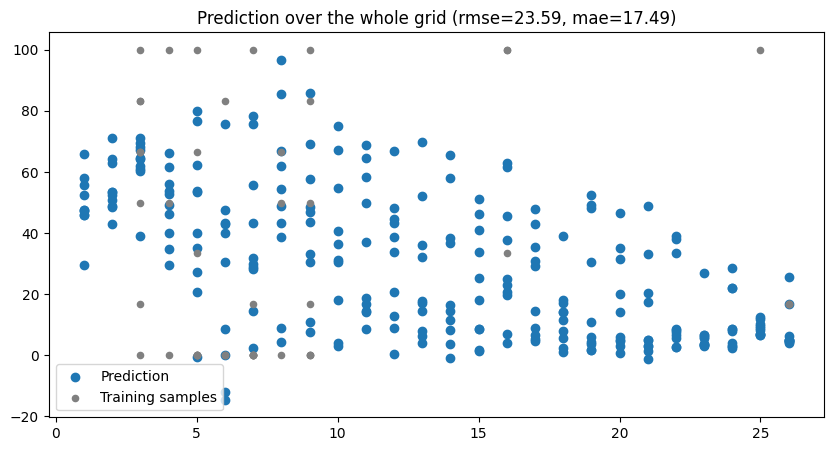

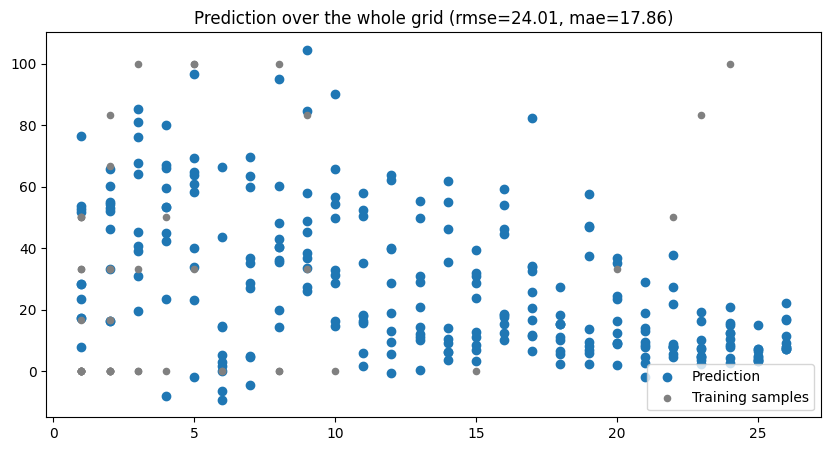

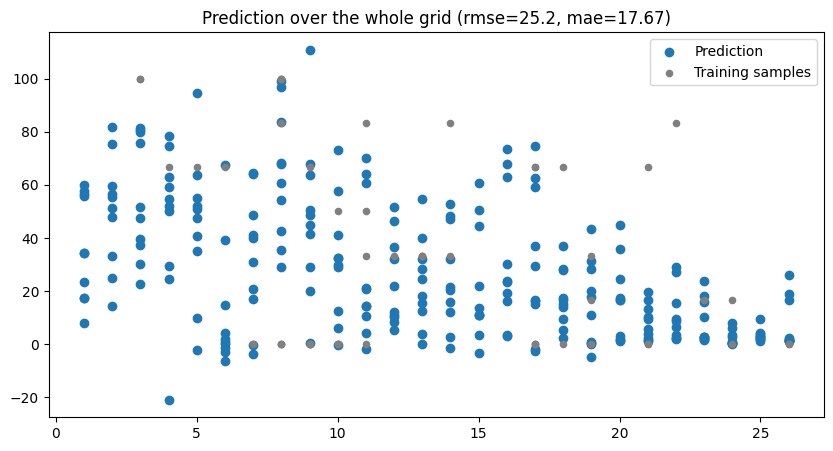

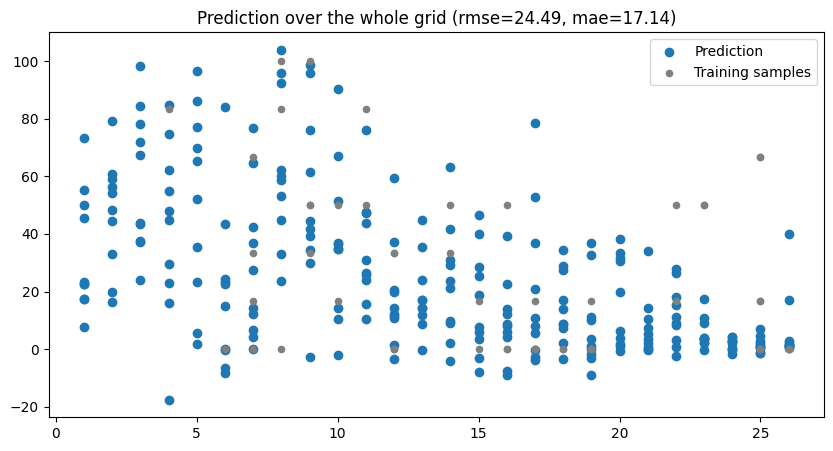

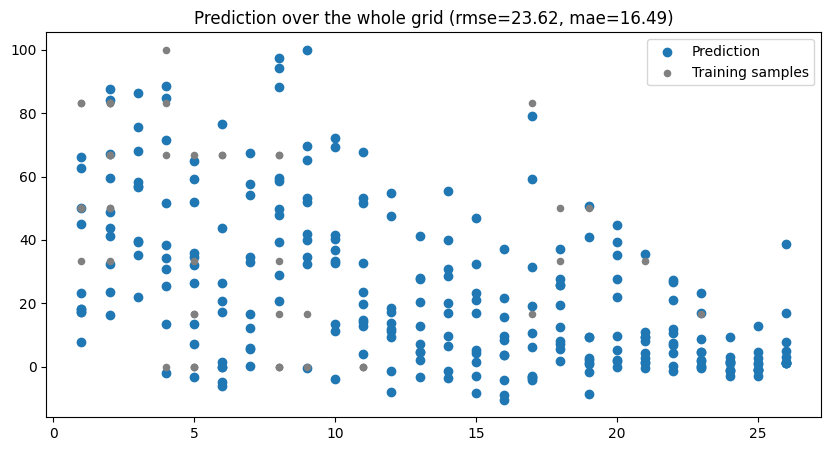

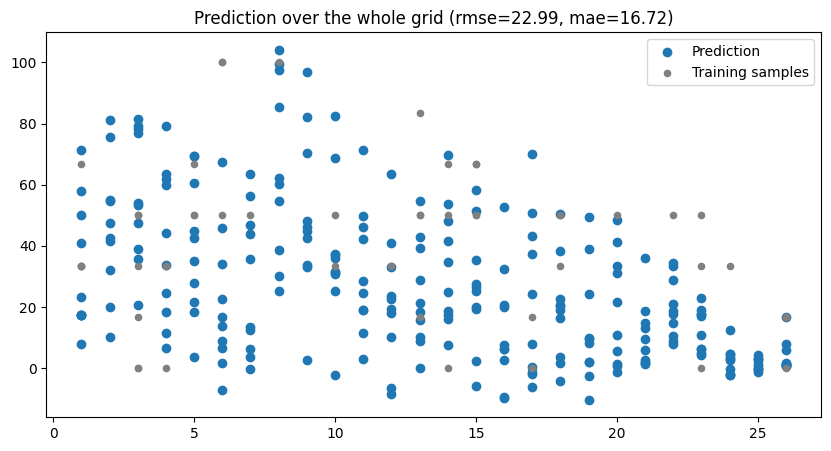

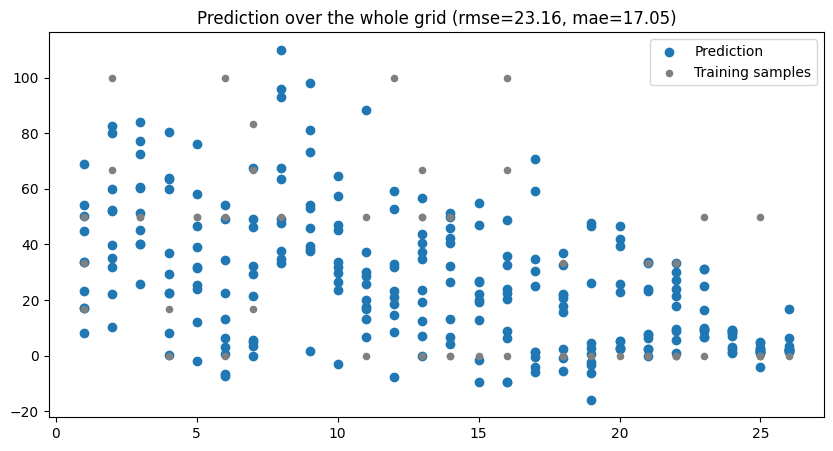

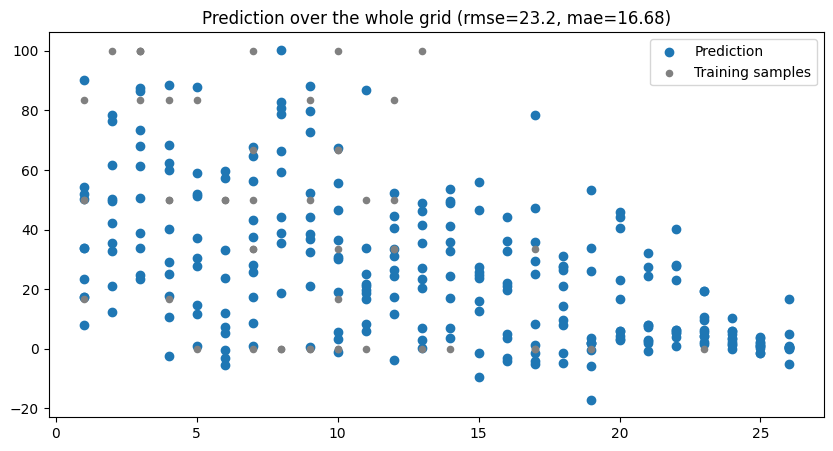

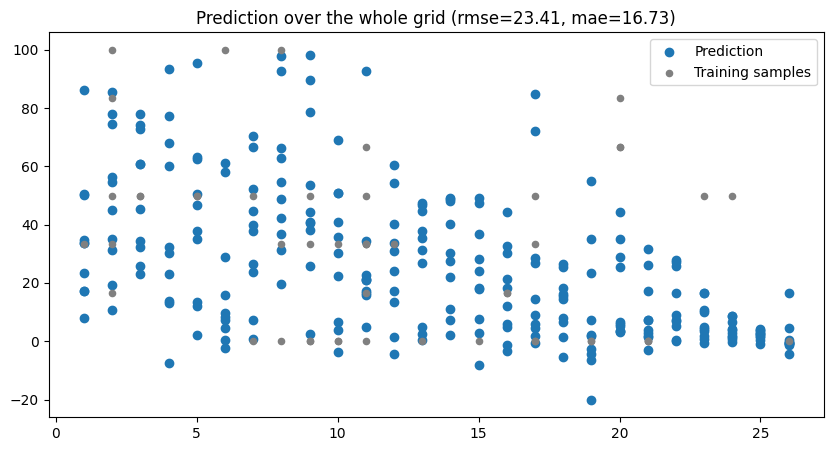

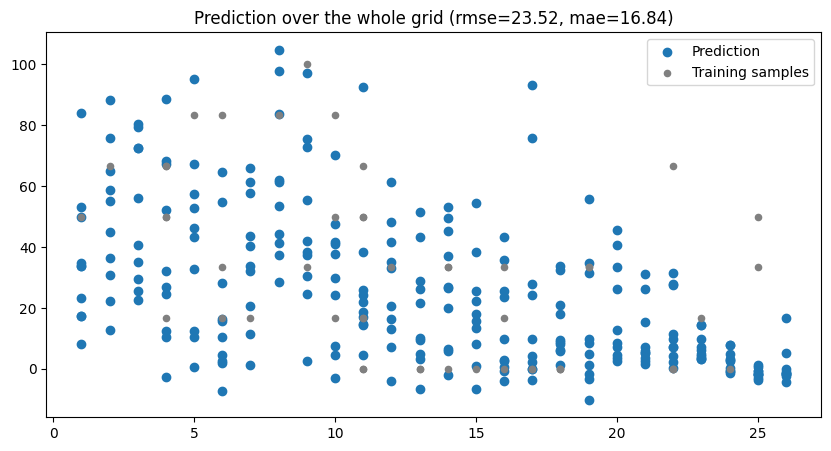

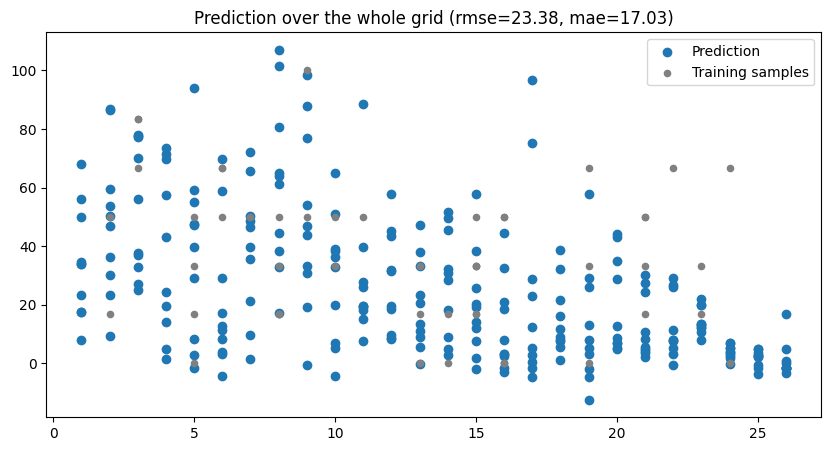

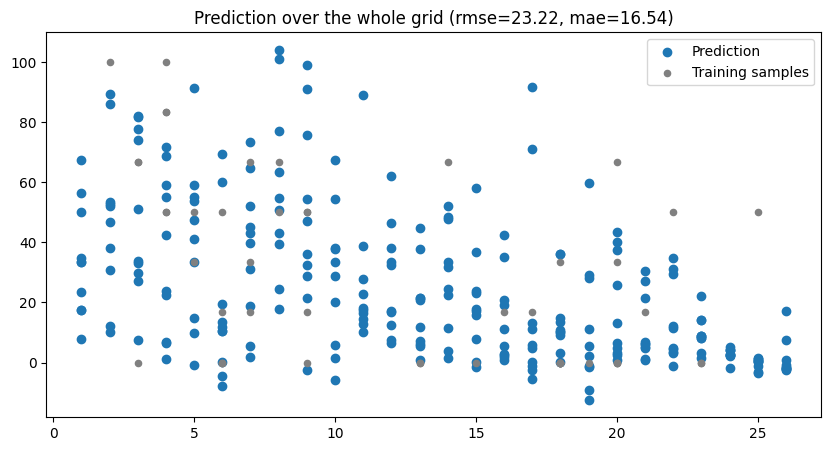

In [ ]:
def regression_std(regressor, x, n_instances=25):
    predictions = np.vstack([est.predict(x.values) for est in regressor.learner_list_])
    std = np.std(predictions, axis=0)
    query_idx = np.argsort(std)[-n_instances:]
    return query_idx, x.iloc[query_idx]

n_regressors = 10  # Number of regressors in the ensemble
n_initial = 50  # Initial amount of random samples

# Get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial * n_regressors, replace=False)
initial_idx = initial_idx.reshape(n_regressors, -1).T  # Reshape to list of lists

# Initialize the ensemble of XGBoost regressors
learner_list = [
    ActiveLearner(
        estimator=XGBRegressor(objective='reg:squarederror'),
        query_strategy=regression_std,
        X_training=x_training.iloc[initial_idx[:, idx_learner]].values,
        y_training=y_training.iloc[initial_idx[:, idx_learner]].values
    )
    for idx_learner in range(n_regressors)
]

# Initializing the CommitteeRegressor with max_std_sampling query strategy
regressor = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

# Initial MSE computation
y_pred = regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

iterations = 12
n_queries = 50

for _ in range(iterations):
    query_idx, query_instance = regressor.query(x_training, n_instances=n_queries)
    regressor.teach(x_training.iloc[query_idx], y_training.iloc[query_idx])

    y_pred = regressor.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Plotting method which you can reuse later
    plt.figure(figsize=(10, 5))
    plt.scatter(x_test['block'], y_pred, label='Prediction')
    plt.scatter(x_training['block'].iloc[query_idx], y_training.iloc[query_idx], c='grey', s=20, label='Training samples')
    plt.title(f'Prediction over the whole grid (rmse={np.round(rmse, 2)}, mae={np.round(mae, 2)})')
    plt.legend()
    plt.show()

###### Random Forest Committee

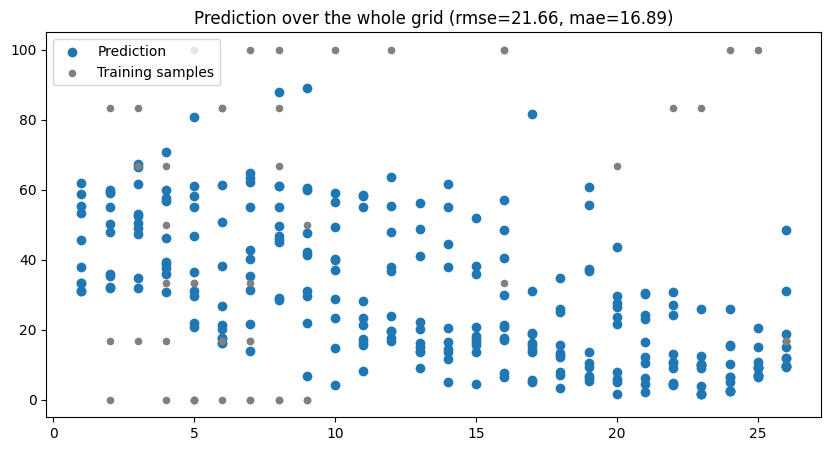

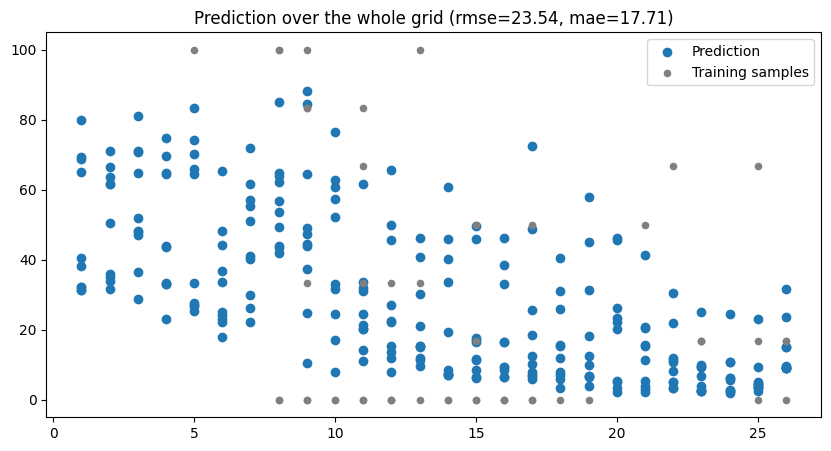

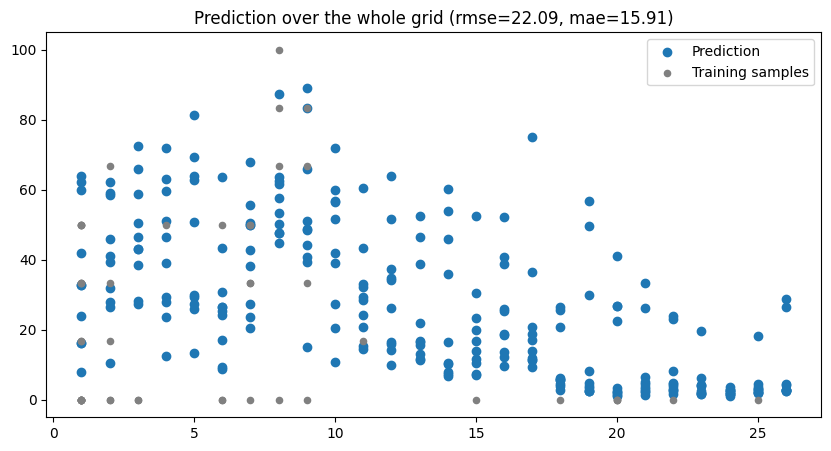

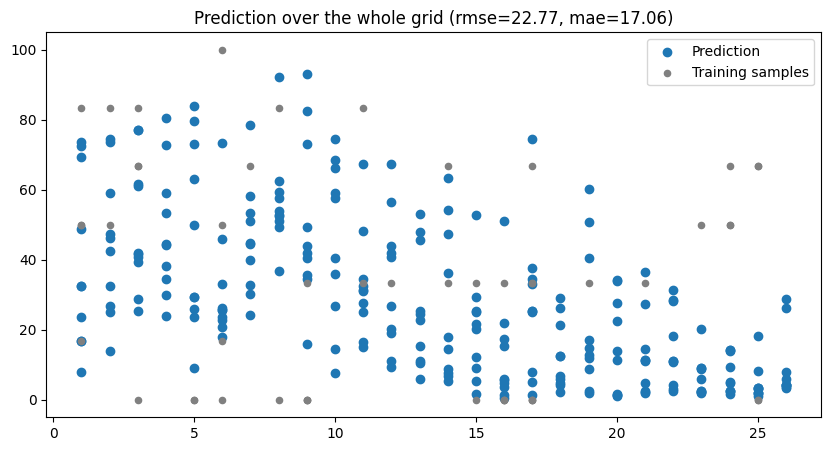

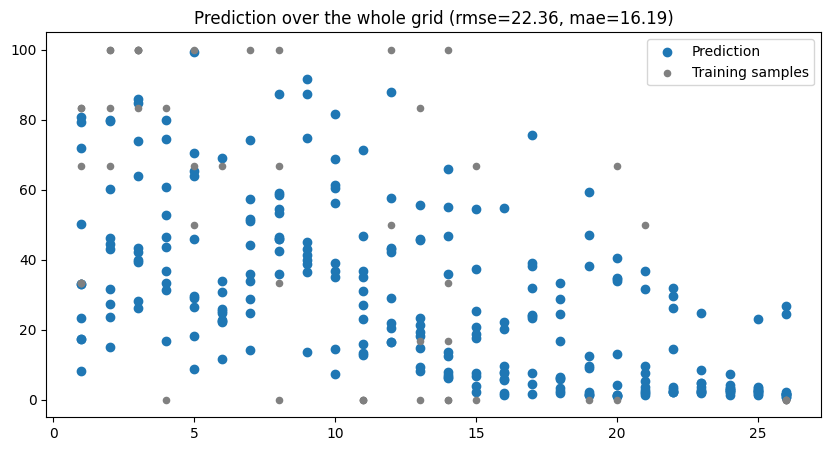

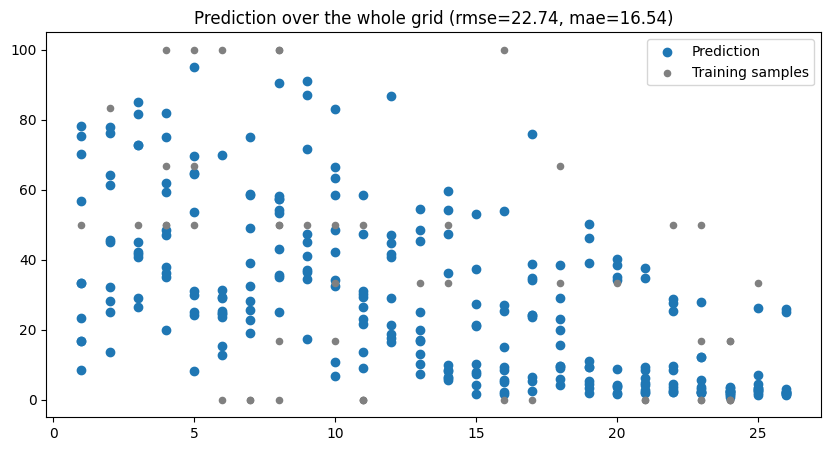

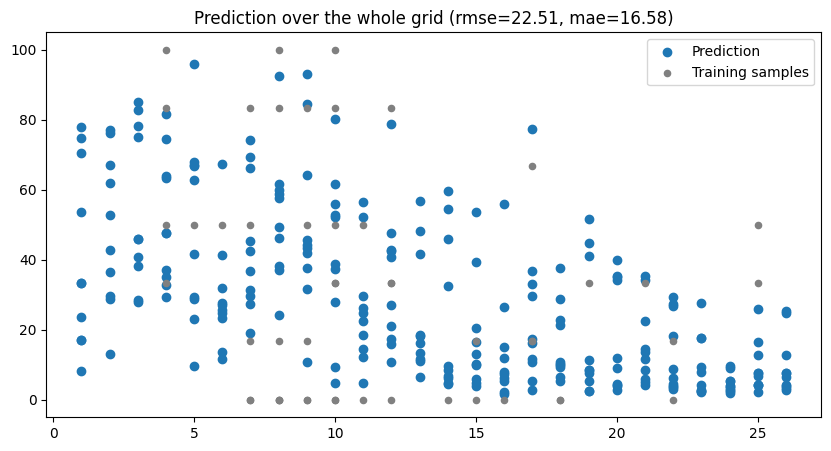

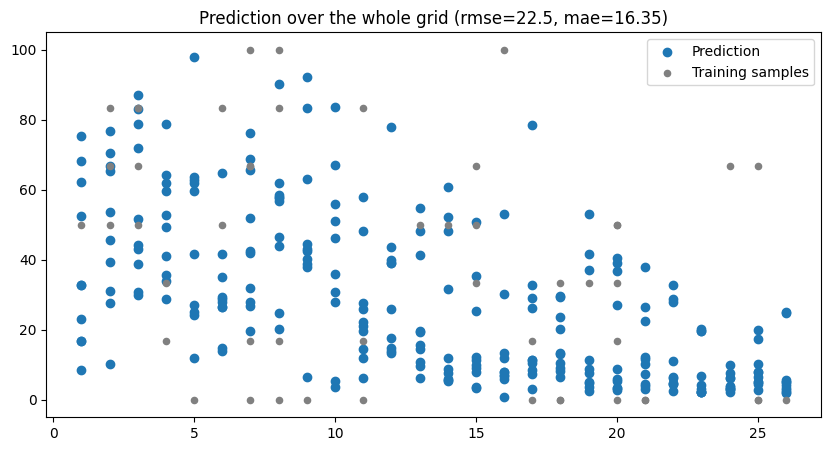

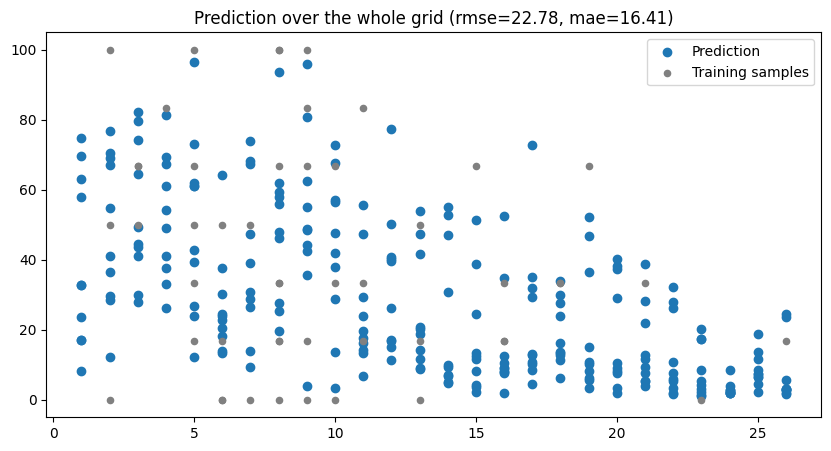

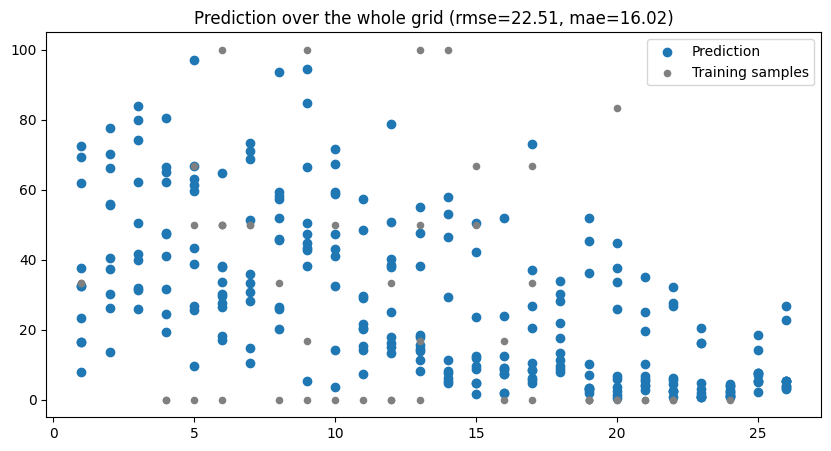

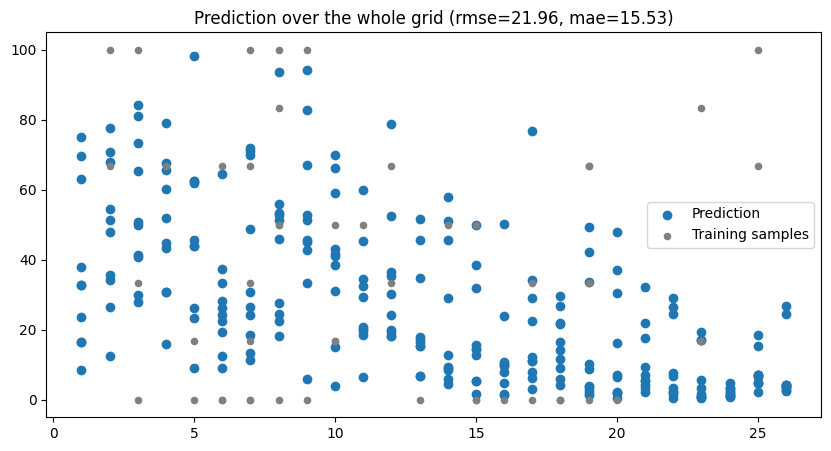

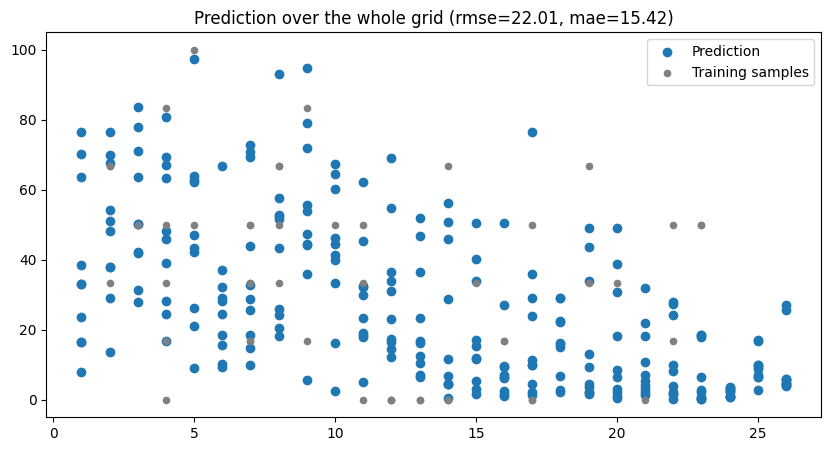

In [ ]:
def regression_std(regressor, x, n_instances=25):
    predictions = np.vstack([est.predict(x.values) for est in regressor.learner_list_])
    std = np.std(predictions, axis=0)
    query_idx = np.argsort(std)[-n_instances:]
    return query_idx, x.iloc[query_idx]

n_regressors = 10  # Number of regressors in the ensemble
n_initial = 50  # Initial amount of random samples

# Get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial * n_regressors, replace=False)
initial_idx = initial_idx.reshape(n_regressors, -1).T  # Reshape to list of lists

# Initialize the ensemble of XGBoost regressors
learner_list = [
    ActiveLearner(
        estimator=RandomForestRegressor(),
        query_strategy=regression_std,
        X_training=x_training.iloc[initial_idx[:, idx_learner]].values,
        y_training=y_training.iloc[initial_idx[:, idx_learner]].values
    )
    for idx_learner in range(n_regressors)
]

# Initializing the CommitteeRegressor with max_std_sampling query strategy
regressor = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

# Initial MSE computation
y_pred = regressor.predict(x_test)

iterations = 12
n_queries = 50

for _ in range(iterations):
    query_idx, query_instance = regressor.query(x_training, n_instances=n_queries)
    regressor.teach(x_training.iloc[query_idx], y_training.iloc[query_idx])

    y_pred = regressor.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    # Plotting method which you can reuse later
    plt.figure(figsize=(10, 5))
    plt.scatter(x_test['block'], y_pred, label='Prediction')
    plt.scatter(x_training['block'].iloc[query_idx], y_training.iloc[query_idx], c='grey', s=20, label='Training samples')
    plt.title(f'Prediction over the whole grid (rmse={np.round(rmse, 2)}, mae={np.round(mae, 2)})')
    plt.legend()
    plt.show()

##### AL modeling passive_profit

In [ ]:
test_sub_num = int(len(passive_profit.subject.unique())*0.2)
test_subjects = list(passive_profit.subject.unique())[-test_sub_num:]
training = passive_profit[~passive_profit['subject'].isin(test_subjects)]
testing = passive_profit[passive_profit['subject'].isin(test_subjects)]

x_training = training[['block','present_score','reward']].reset_index(drop = True)
y_training = training['risky_choice_block_percent'].reset_index(drop = True)

x_test = testing[['block','present_score','reward']].reset_index(drop = True)
y_test = testing['risky_choice_block_percent'].reset_index(drop = True)

###### Gaussian Process AL

In [ ]:

def GP_regression_std(regressor, x, n_instances=25):
    _, std = regressor.predict(x, return_std=True)
    query_idx = np.argsort(std)[-n_instances:]
    return query_idx, x.iloc[query_idx]

n_initial = 50  # initial amount of random samples

# get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial, replace=False)
x_training_init, y_training_init = x_training.iloc[initial_idx], y_training.iloc[initial_idx]

# define a kernel for the Gaussian process regressor
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# initialize the regressor and train it with the initial training data
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=x_training_init.values,
    y_training=y_training_init.values
)

In [ ]:

y_pred, y_std = regressor.predict(x_test, return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

# compute the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

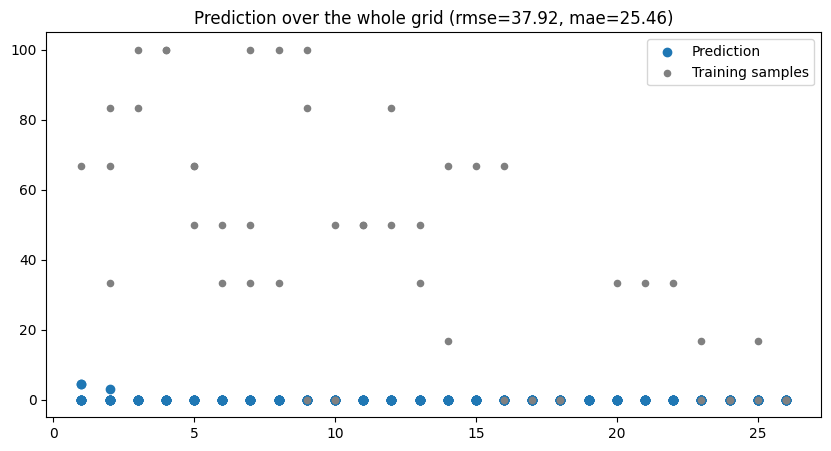

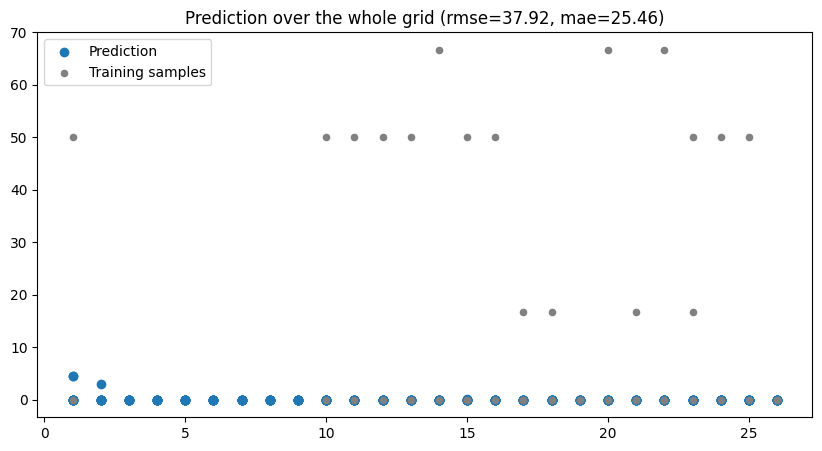

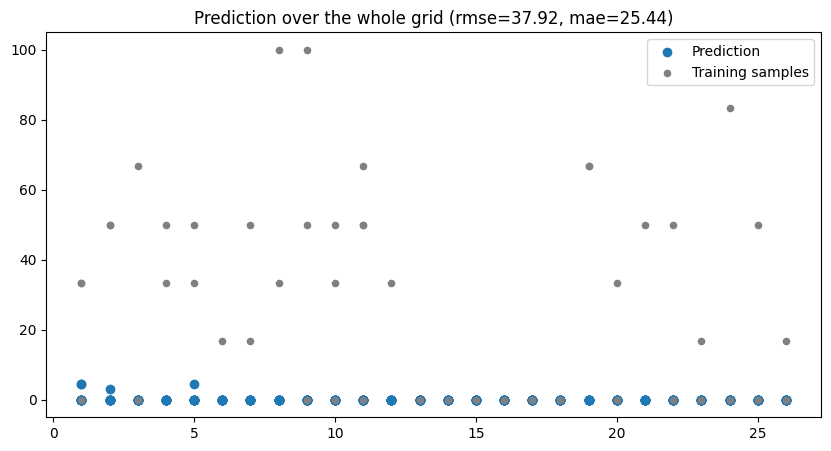

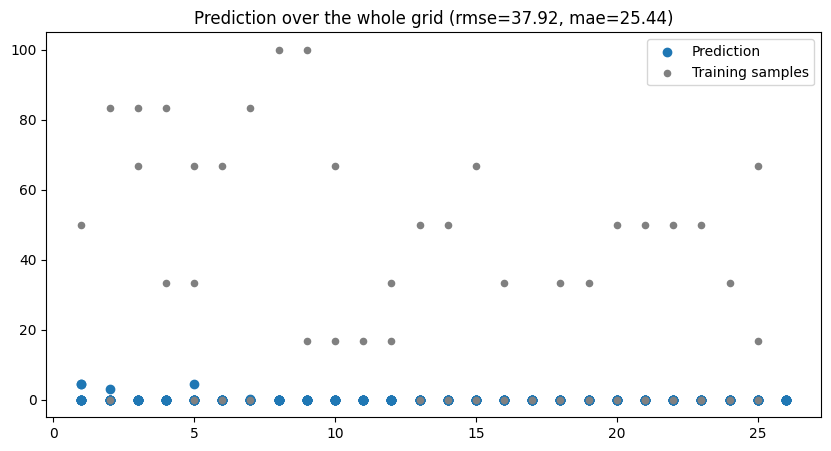

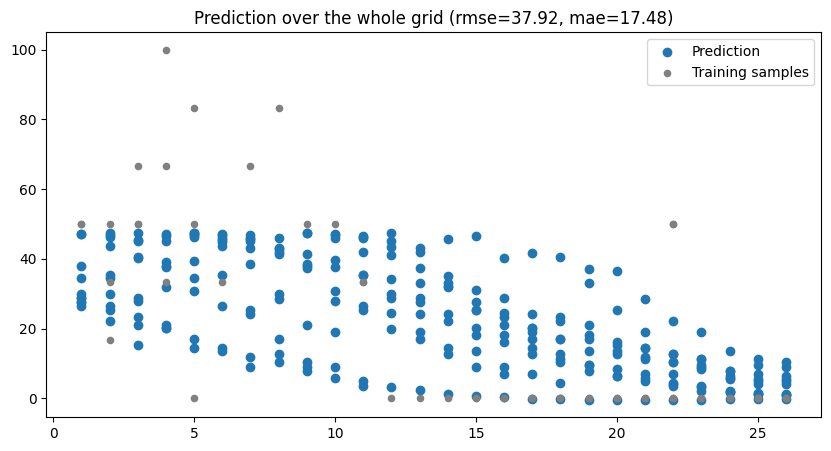

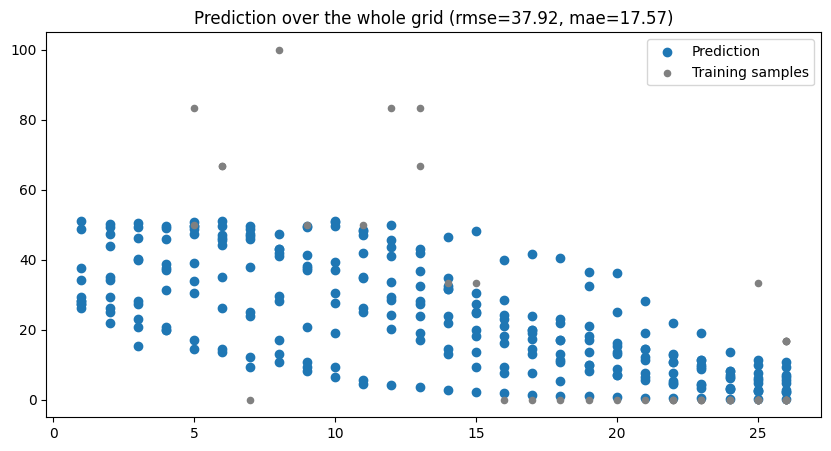

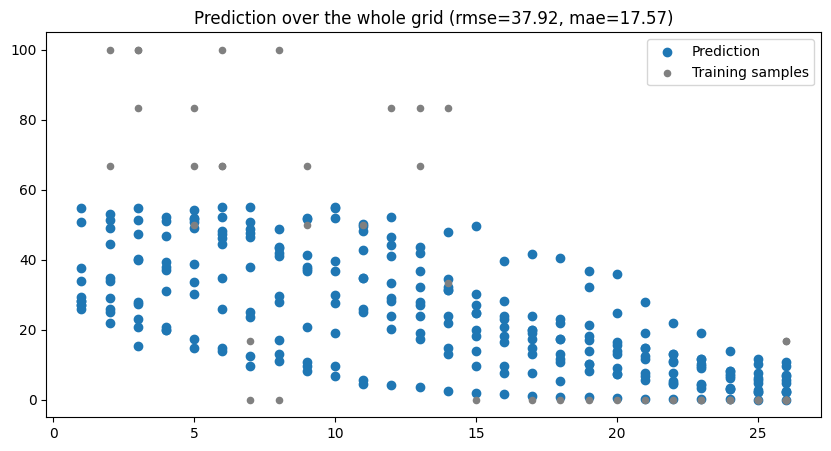

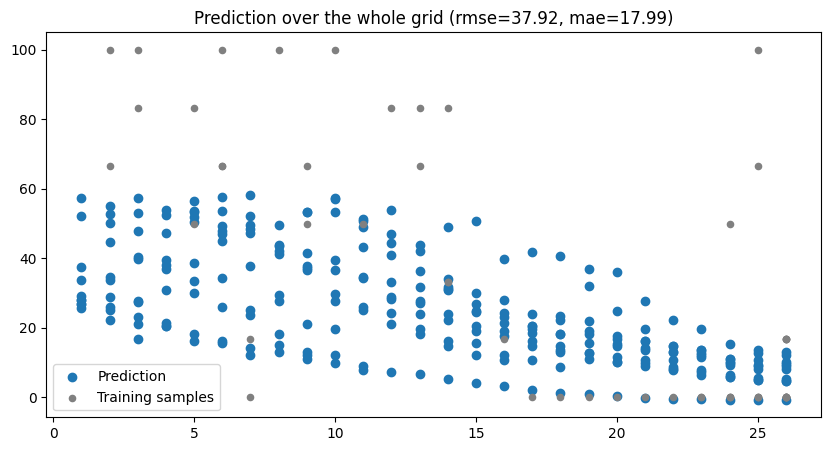

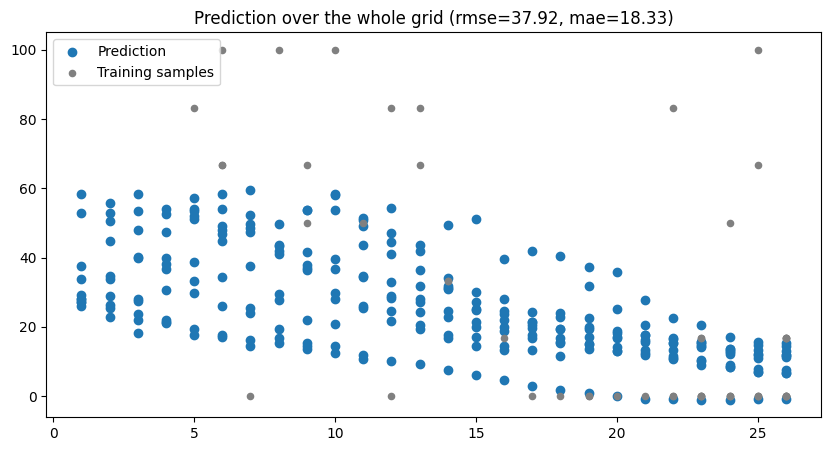

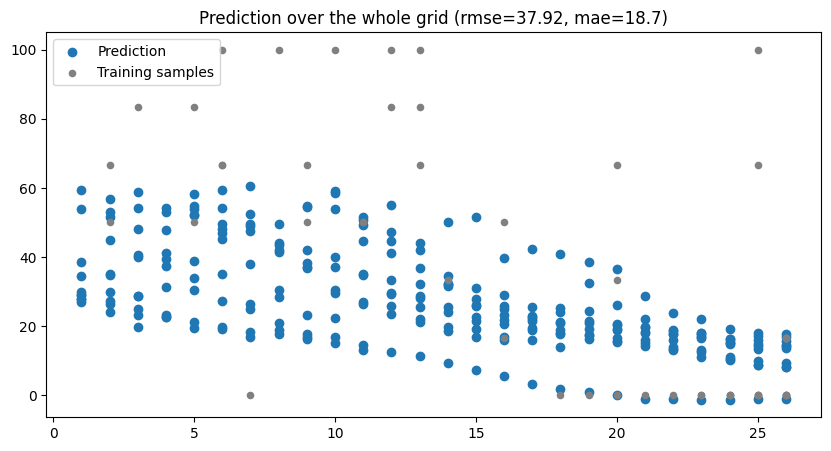

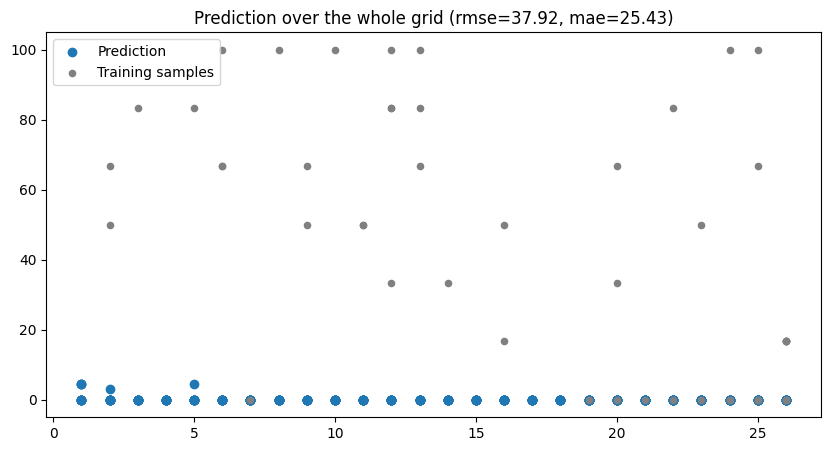

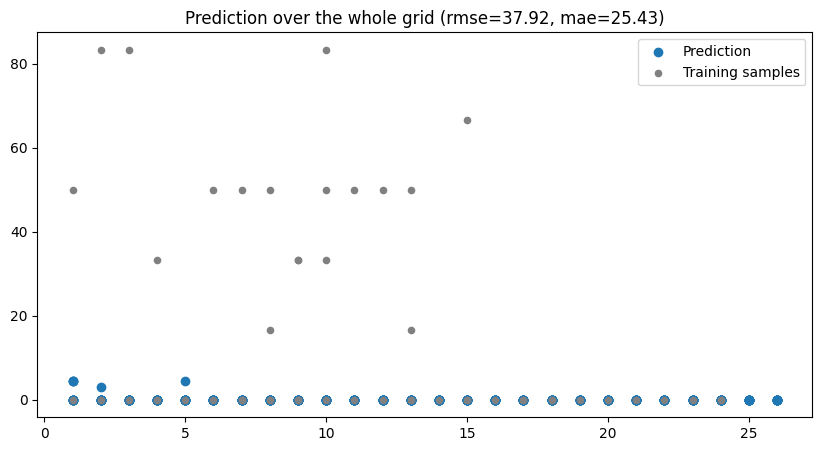

In [ ]:
iterations = 12
n_queries = 50

for _ in range(iterations):
    query_idx, query_instance = regressor.query(x_training, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
    regressor.teach(x_training.iloc[query_idx], y_training.iloc[query_idx])  # fit the model with the query points

    # get the predicted response and the standard deviation
    y_pred = regressor.predict(x_test)
    # y_pred, y_std = y_pred.ravel(), y_std.ravel()

    # compute the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # plotting method which we can reuse later
    plt.figure(figsize=(10, 5))
    plt.scatter(x_test['block'], y_pred, label='Prediction')
    plt.scatter(x_training['block'].iloc[query_idx], y_training.iloc[query_idx], c='grey', s=20, label='Training samples')
    plt.title(f'Prediction over the whole grid (rmse={np.round(rmse, 2)}, mae={np.round(mae, 2)})')
    plt.legend()
    plt.show()

###### XGB AL

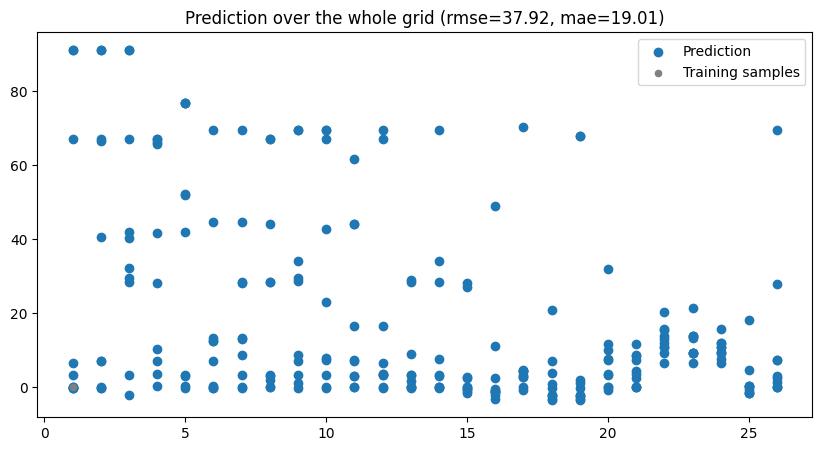

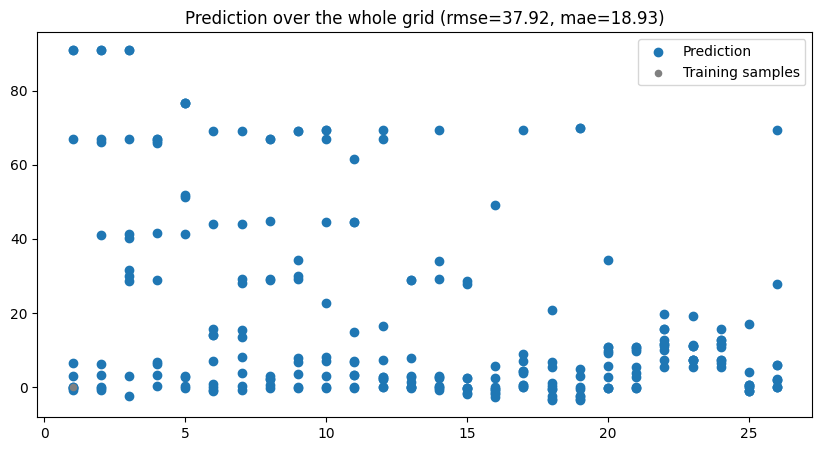

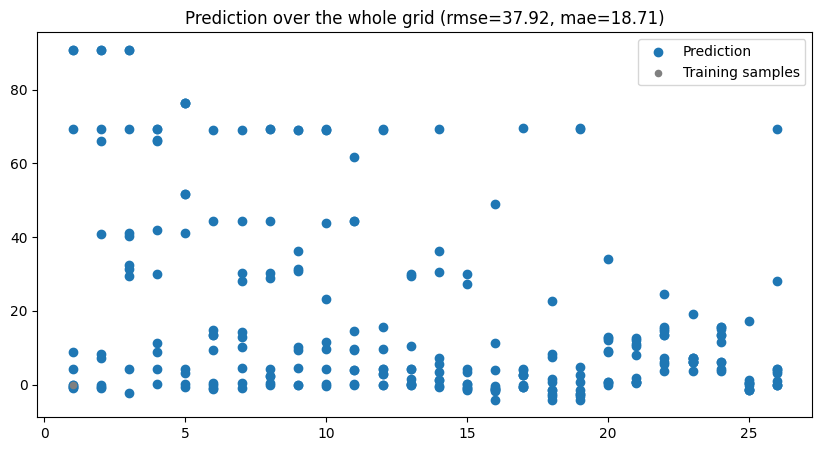

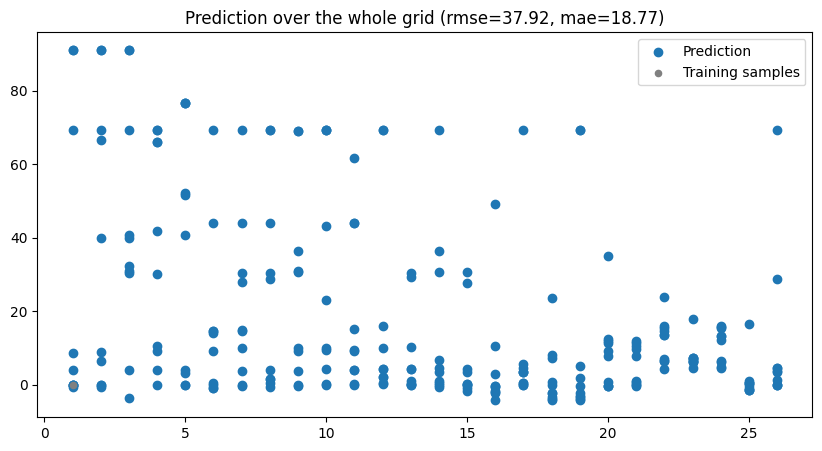

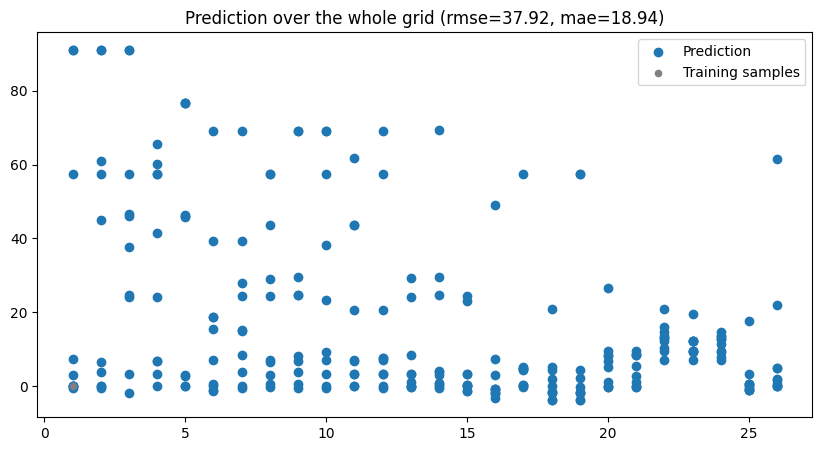

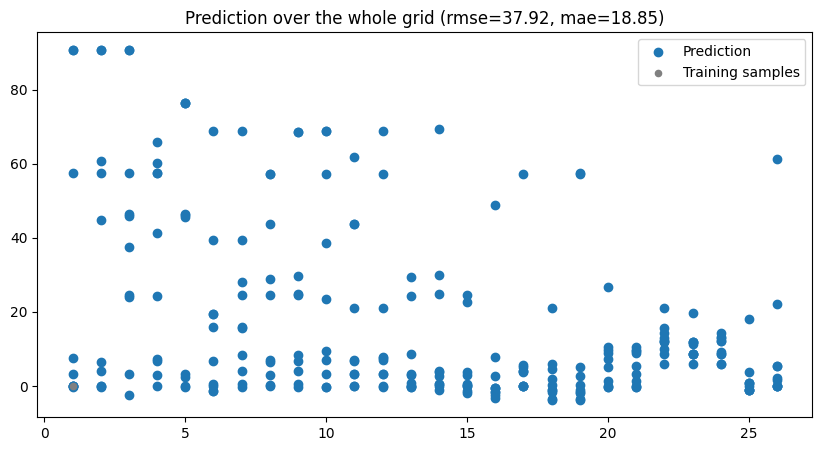

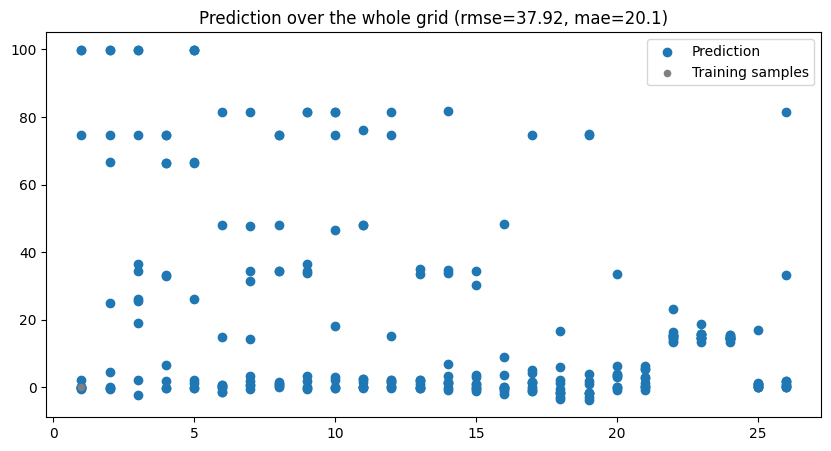

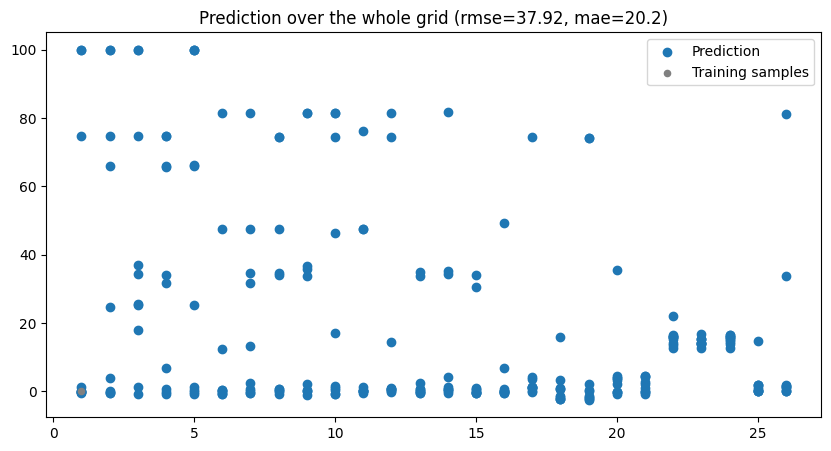

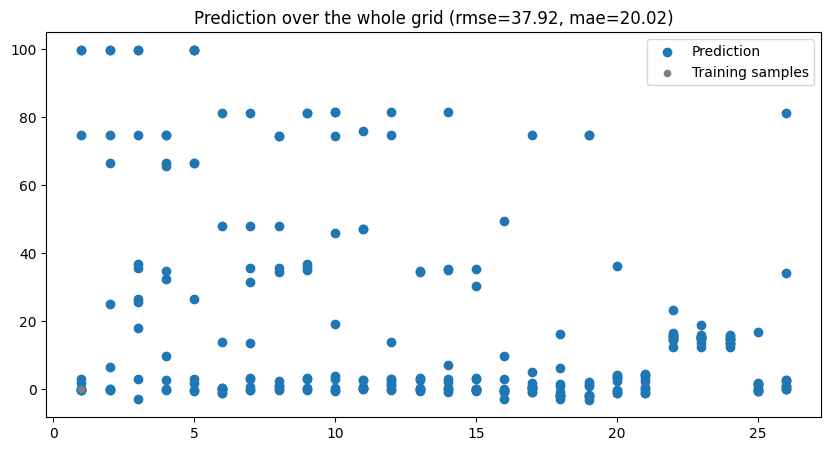

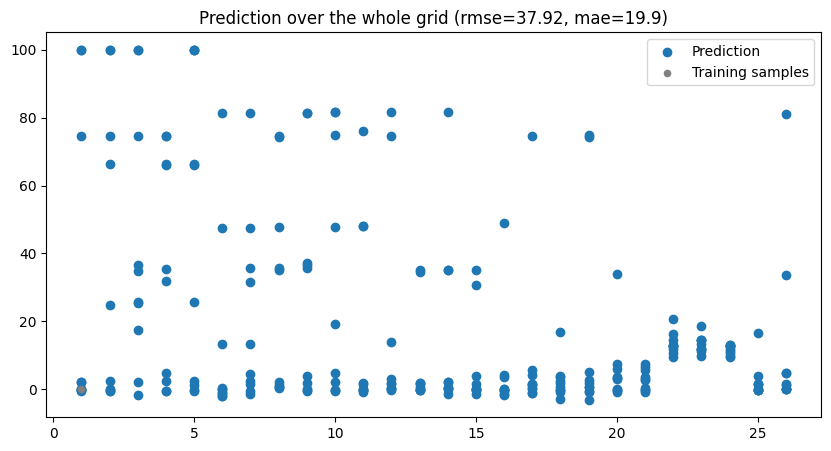

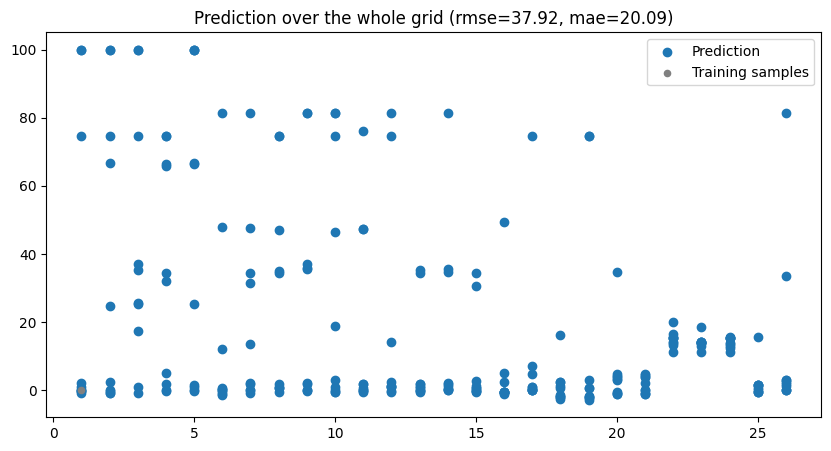

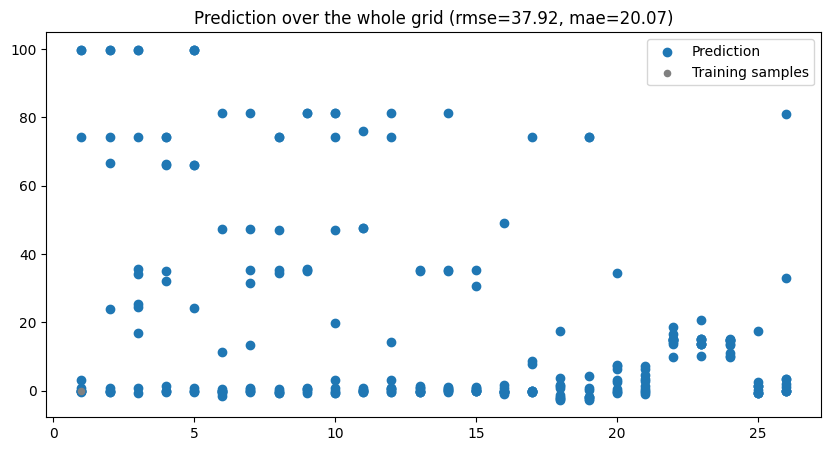

In [ ]:
def regression_std(regressor, x, n_instances=25):
    predictions = regressor.predict(x.values, output_margin=True)
    std = np.std(predictions)
    query_idx = np.argsort(std)[-n_instances:]
    return query_idx, x.iloc[query_idx]

n_initial = 25  # Initial amount of random samples

# Get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial, replace=False)
x_training_init, y_training_init = x_training.iloc[initial_idx].values, y_training.iloc[initial_idx].values

# Initialize the XGBoost regressor
regressor = ActiveLearner(
    estimator=XGBRegressor(objective='reg:squarederror'),
    query_strategy=regression_std,
    X_training=x_training_init,
    y_training=y_training_init
)

# Initial MSE computation
y_pred = regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

iterations = 12
n_queries = 50

for _ in range(iterations):
    query_idx, query_instance = regressor.query(x_training, n_instances=n_queries)
    regressor.teach(x_training.iloc[query_idx], y_training.iloc[query_idx])

    y_pred = regressor.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # plotting method which we can reuse later
    plt.figure(figsize=(10, 5))
    plt.scatter(x_test['block'], y_pred, label='Prediction')
    plt.scatter(x_training['block'].iloc[query_idx], y_training.iloc[query_idx], c='grey', s=20, label='Training samples')
    plt.title(f'Prediction over the whole grid (rmse={np.round(rmse, 2)}, mae={np.round(mae, 2)})')
    plt.legend()
    plt.show()


###### Random Forest AL

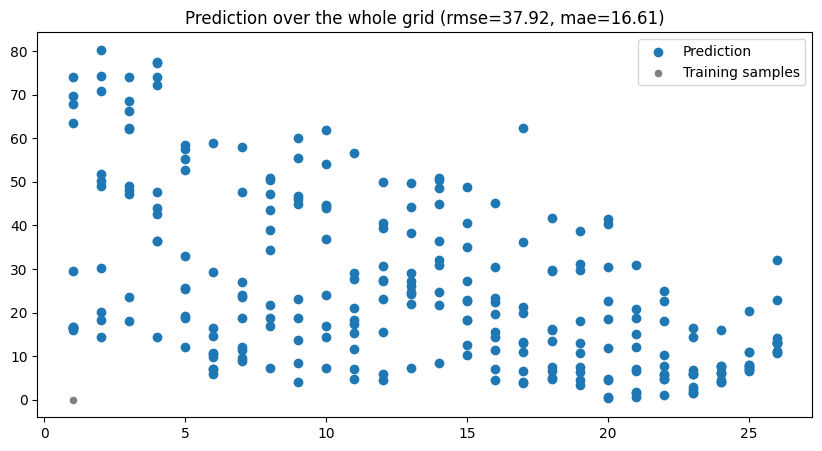

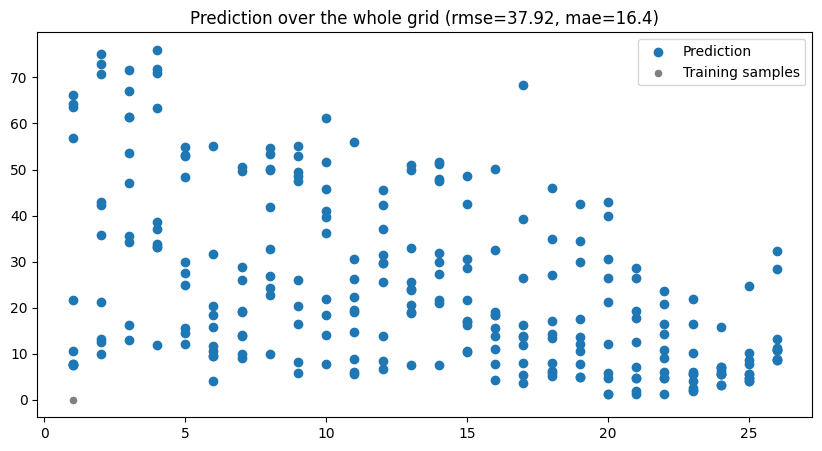

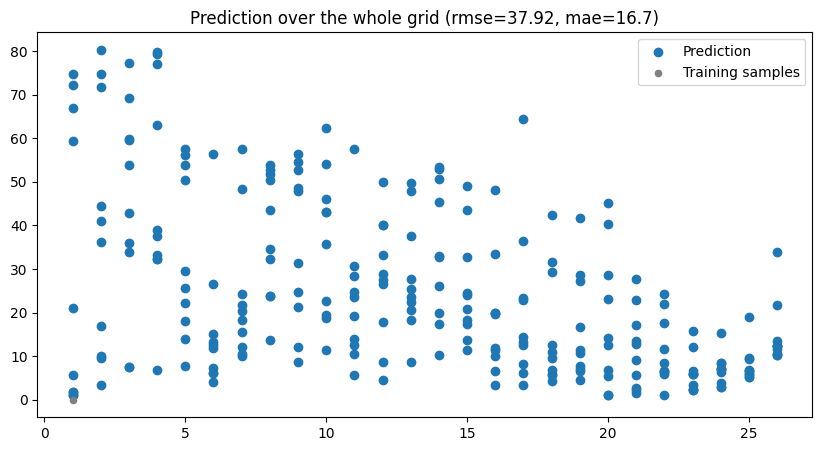

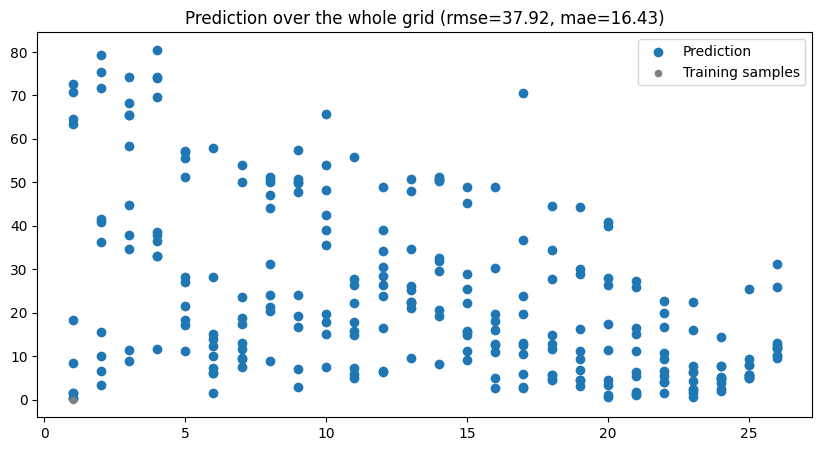

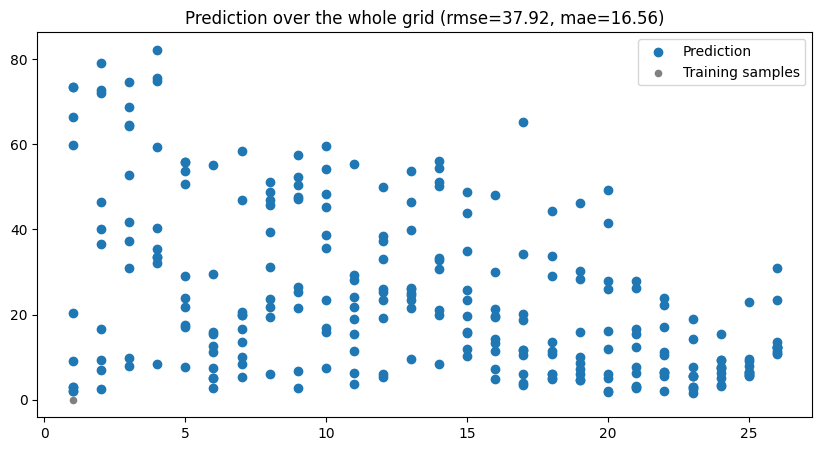

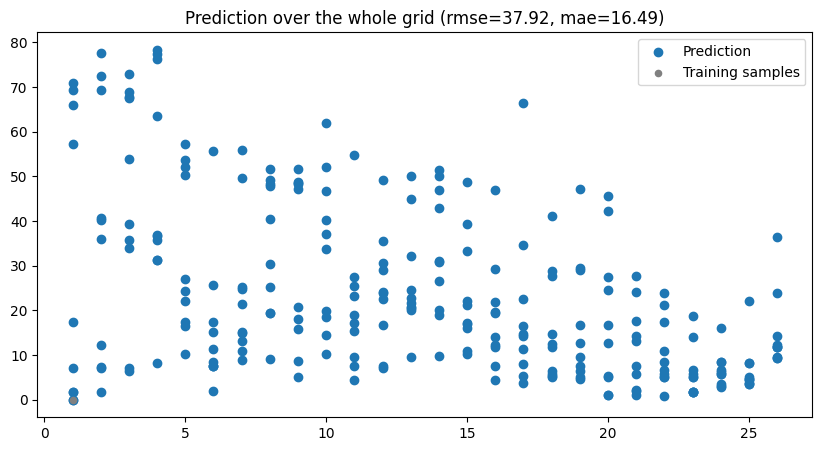

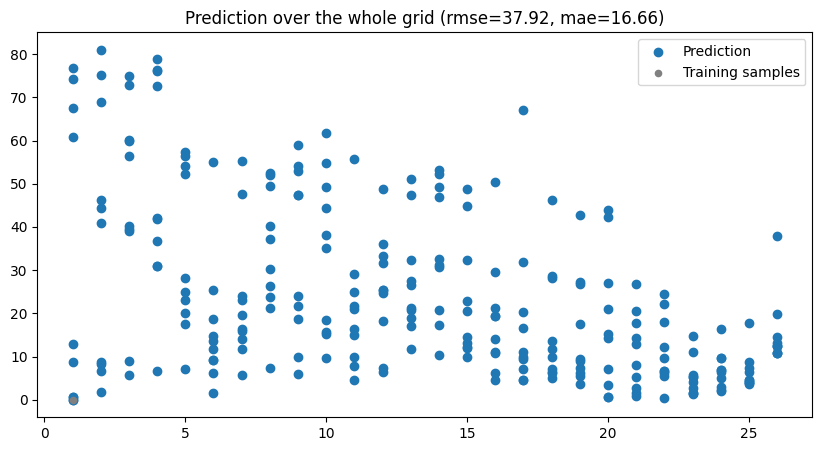

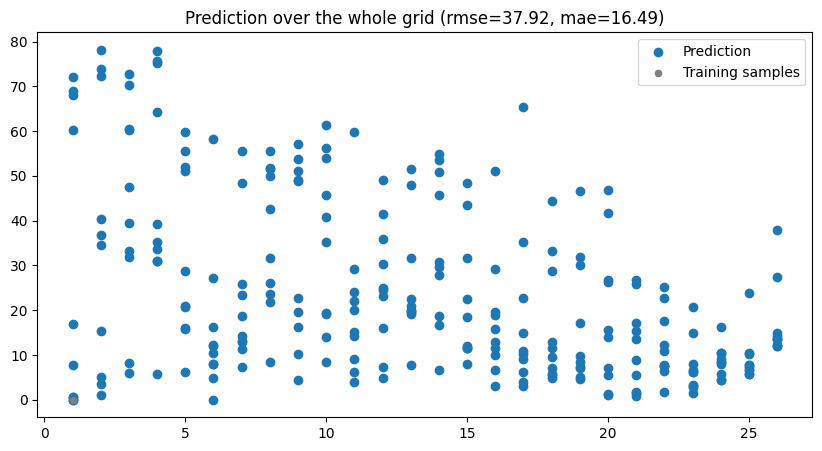

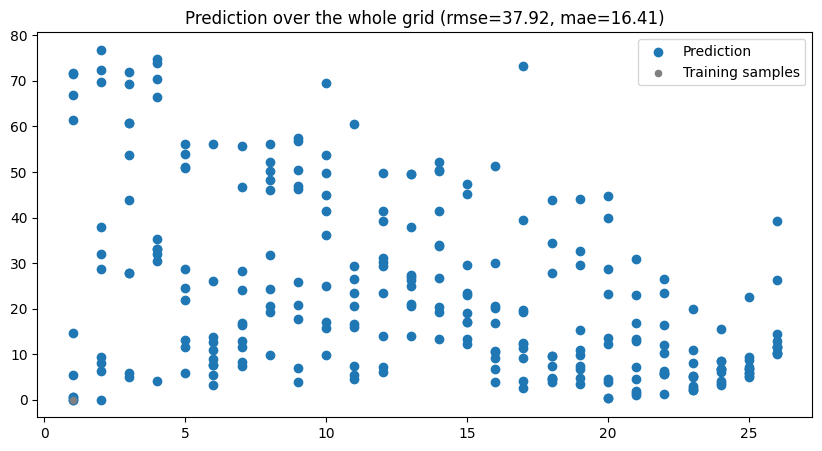

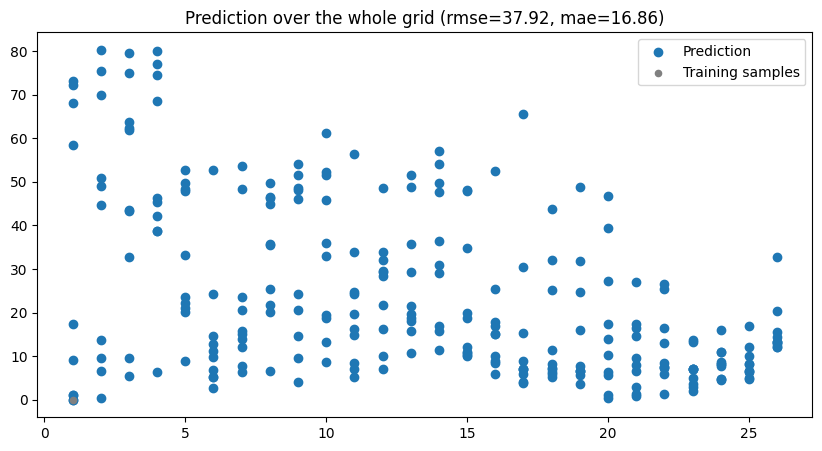

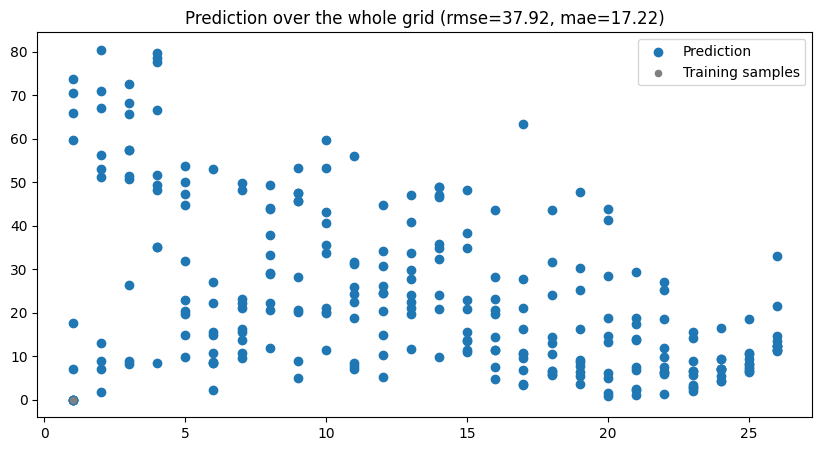

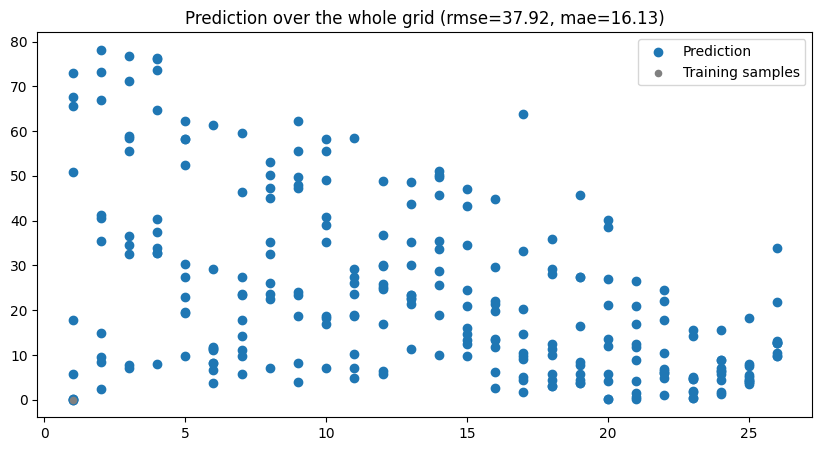

In [ ]:
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def regression_std(regressor, x, n_instances=25):
    pred = regressor.predict(x.values)
    std = np.std(pred, axis=0)
    query_idx = np.argsort(std)[-n_instances:]
    return query_idx, x.iloc[query_idx]

n_initial = 50  # Initial amount of random samples

# Get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial, replace=False)
x_training_init, y_training_init = x_training.iloc[initial_idx].values, y_training.iloc[initial_idx].values

# Initialize the RandomForestRegressor
regressor = ActiveLearner(
    estimator=RandomForestRegressor(),
    query_strategy=regression_std,
    X_training=x_training_init,
    y_training=y_training_init
)

# Initial MSE computation
y_pred = regressor.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

iterations = 12
n_queries = 50

for _ in range(iterations):
    query_idx, query_instance = regressor.query(x_training, n_instances=n_queries)
    regressor.teach(x_training.iloc[query_idx], y_training.iloc[query_idx])

    y_pred = regressor.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # plotting method which we can reuse later
    plt.figure(figsize=(10, 5))
    plt.scatter(x_test['block'], y_pred, label='Prediction')
    plt.scatter(x_training['block'].iloc[query_idx], y_training.iloc[query_idx], c='grey', s=20, label='Training samples')
    plt.title(f'Prediction over the whole grid (rmse={np.round(rmse, 2)}, mae={np.round(mae, 2)})')
    plt.legend()
    plt.show()


### Using the estimators directly on the entire training dataset without AL and querying

In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(x_training, y_training)
y_pred_rf = rf_regressor.predict(x_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print('rmse={}, mae={}'.format(np.round(rmse_rf, 2), np.round(mae_rf, 2)))

rmse=21.46, mae=14.6


In [ ]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(x_training, y_training)
y_pred_xgb = xgb_regressor.predict(x_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print('rmse={}, mae={}'.format(np.round(rmse_xgb, 2), np.round(mae_xgb, 2)))

rmse=24.06, mae=16.62


In [ ]:
from sklearn.linear_model import LinearRegression
lr_regressor = LinearRegression()
lr_regressor.fit(x_training, y_training)
y_pred_lr = lr_regressor.predict(x_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('rmse={}, mae={}'.format(np.round(rmse_lr, 2), np.round(mae_lr, 2)))

rmse=23.44, mae=18.11
